In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy

## Derivation

### Kinetic Energy
In coordinates $(r,\theta)$ and $(\dot r, \dot \theta)$. Where $r=l_0+\Delta r$

$T=\frac12mv^2 = \frac12m(\dot r^2 + r^2\dot\theta^2)$

$V=mgh+\frac12k\Delta r^2 = -mgr\cos\theta + \frac12 k(r-l_0)^2$

$\mathcal{L} = T-V = \frac12m(\dot r^2 + r^2\dot\theta^2) + mgr\cos\theta - \frac12 k(r-l_0)^2$

[30.55261213  0.93839928]


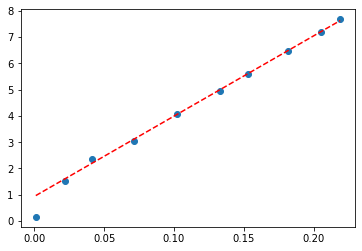

In [12]:
x = np.array([1, 22, 41, 71, 102, 133, 153, 182, 205, 219])*1e-3 # millimeter with meter conversion
w = np.array([-16, -157, -239, -310, -415, -506, -571, -658, -735, -783])*-1e-3*9.81 # gram with kilogram to newton conversion

f = lambda x, m, b: m*x+b

popt, pcov = curve_fit(f, x[1:], w[1:], [-3, 0])
print(popt)

plt.scatter(x,w)
plt.plot(x, f(x, *popt), 'r--')
plt.show()

Before:
T = 0.000e+00J
V = -7.223e-01J
Total = -7.223e-01J
After:
T = 5.559e-01J
V = -1.307e+00J
Total = -7.506e-01J


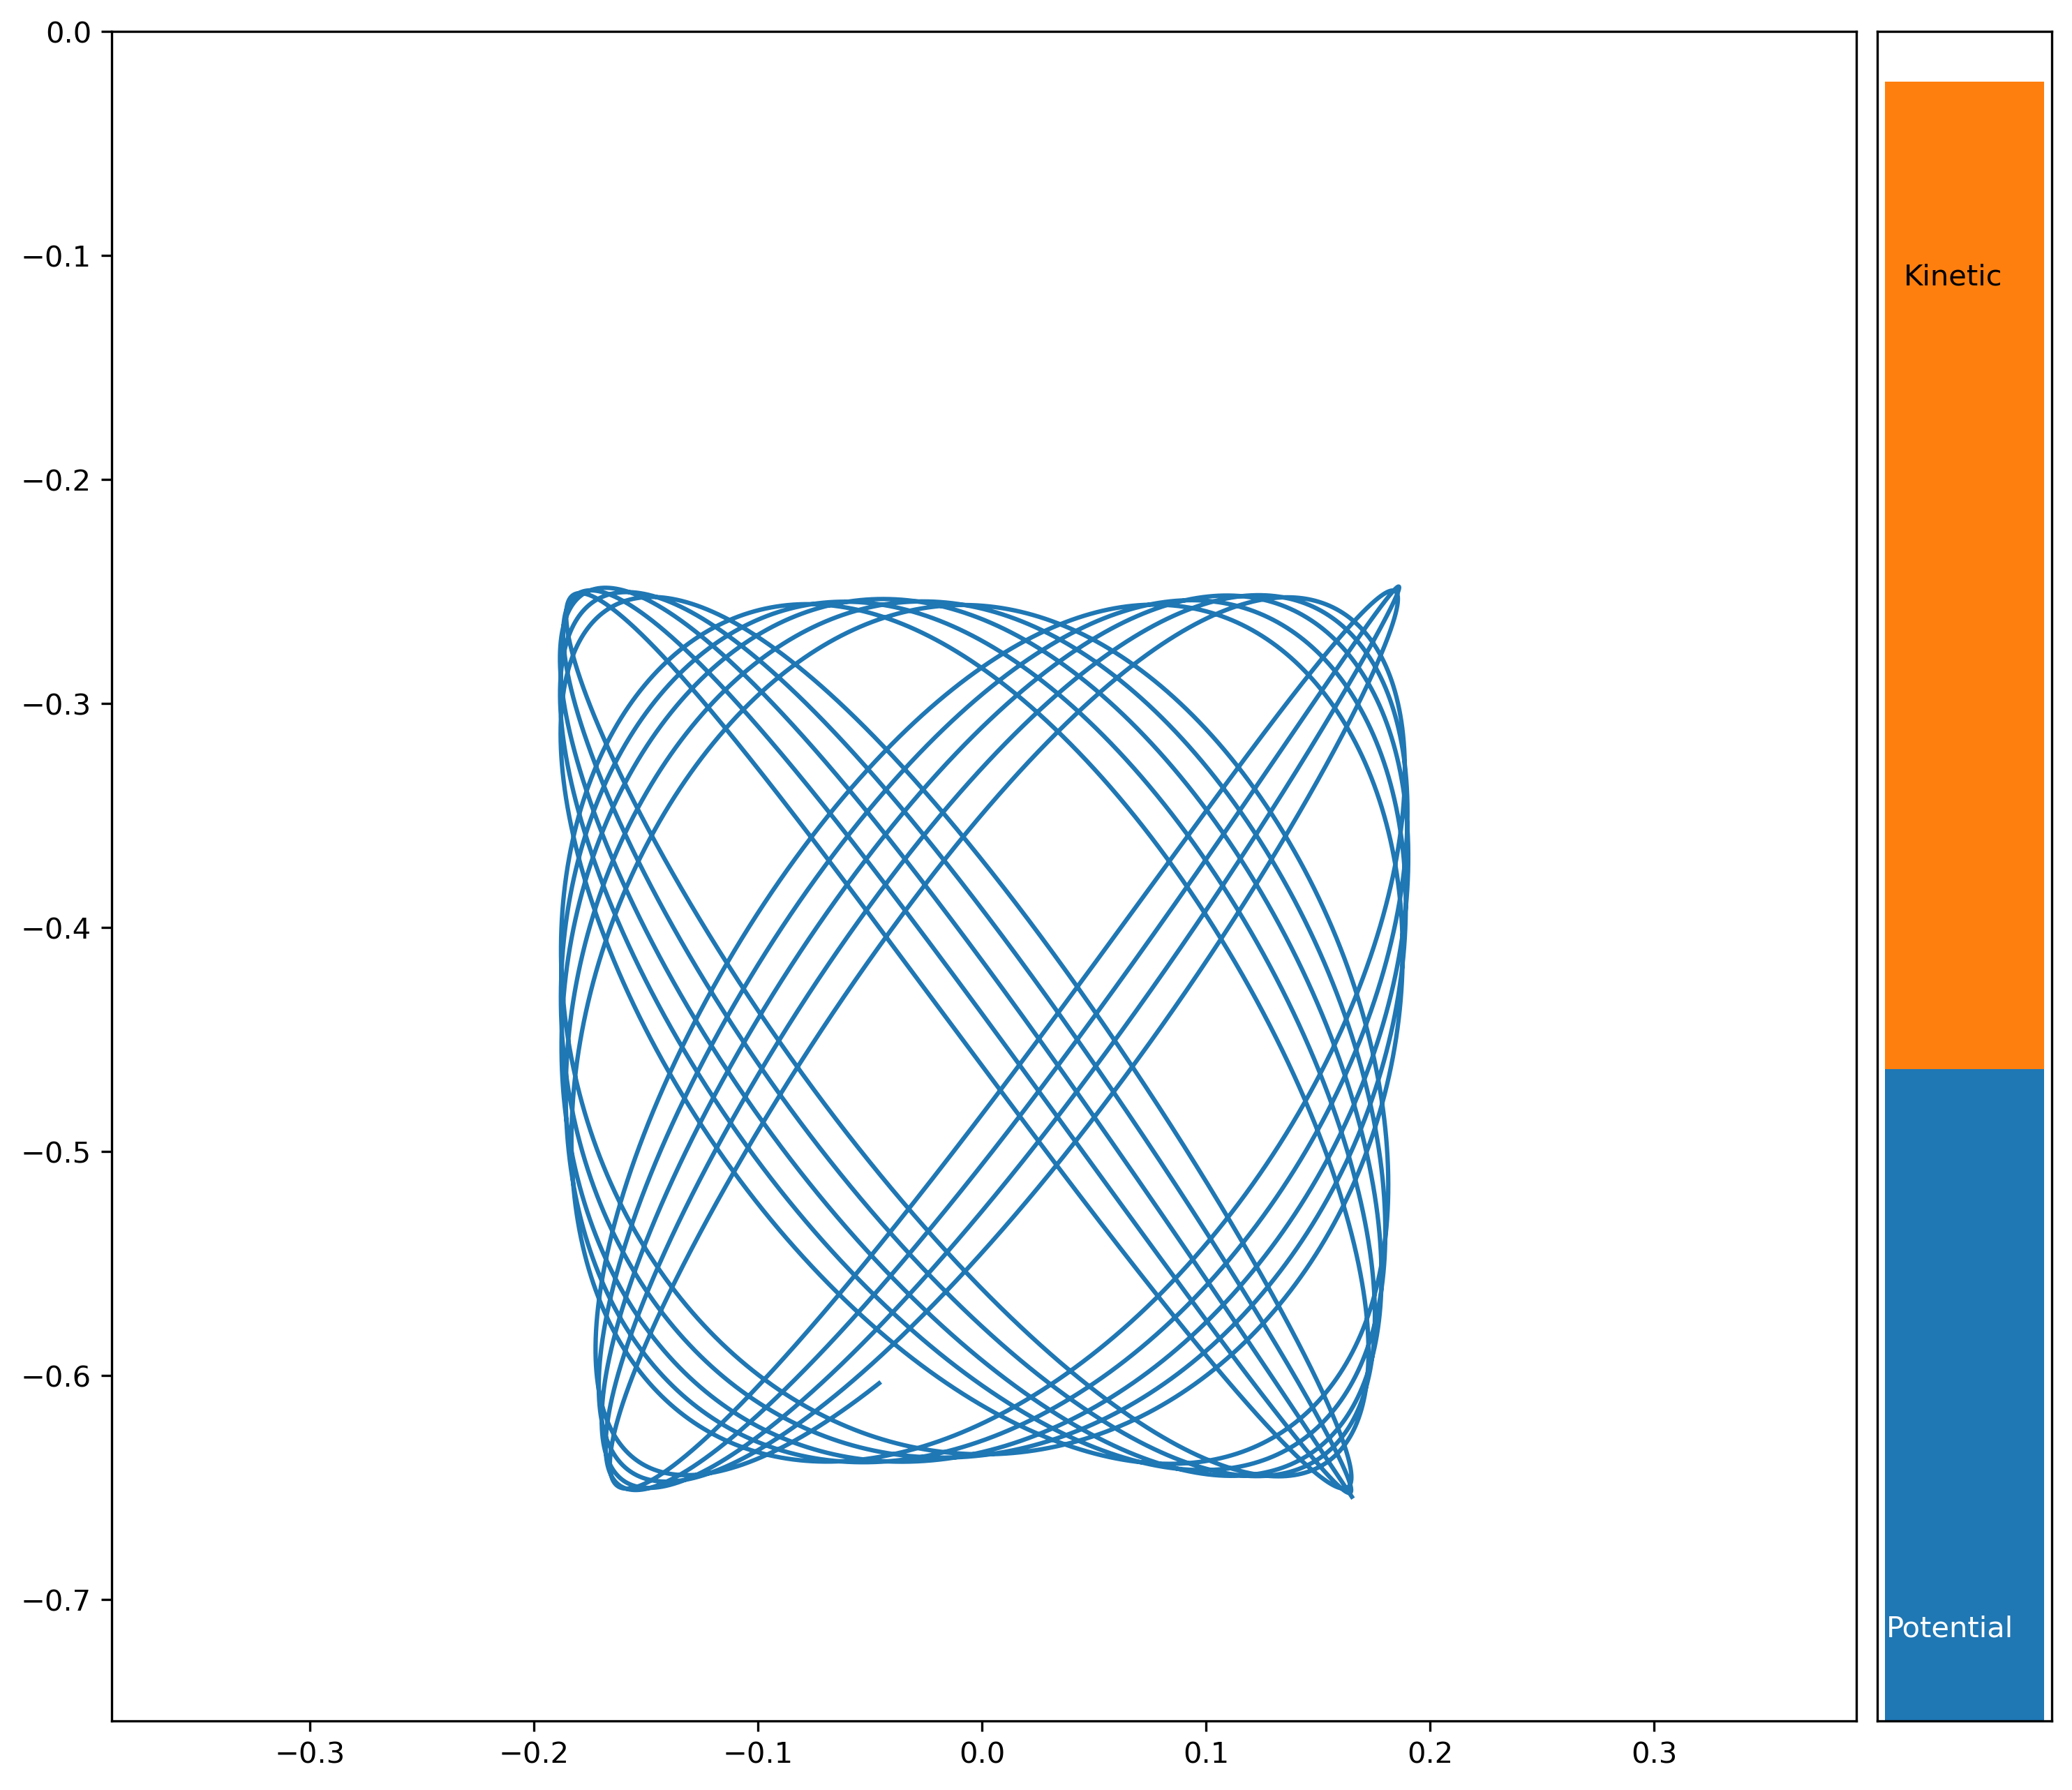

In [10]:
# Constants

l0 = 0.123 # meters
g = 9.81 # meters per second per second
k = 30.56 # Newtons per meter
m = 1.031 # kilograms
h = 0*l0 # meters - height of pivot (for potentential energy calculation)

beta = 1.6e-4 # newton second per meter^2
gamma = 0.25 # newton second^2 per meter^4
diameter = 0.1 # meters

springdiameter = 0.015 # meters

time = 20 # seconds
timestep = 0.0001 # seconds

# Define the derived equations of motion and energy

def rquaddrag(dr):
    return -1*np.sign(dr)*gamma*diameter**2*dr*dr/m

def thetaquaddrag(r, dtheta):
    return -1*np.sign(dtheta)*gamma*diameter**2*r*r*dtheta**2/m

def rda(r, dr, theta, dtheta):
    return r*dtheta*dtheta + g*np.cos(theta) - k/m*(r-l0) + rquaddrag(dr)

def thetada(r, rv, theta, thetav):
    return -g/r*np.sin(theta) - 2*rv*thetav/r + thetaquaddrag(r, thetav)

def kinenergy(r, rv, thetav):
    return 0.5*m*rv*rv + 0.5*m*r*r*thetav*thetav

def potenergy(r, theta):
    return m*g*(l0-r*np.cos(theta)) + 0.5*k*(r-l0)**2
    

# Initial conditions

theta = 0.0787*np.pi # radians for run 1
# theta = 0.2349*np.pi # radians for run 2
thetav = 0 # radians per second
r0, deltar = m*g/k*np.cos(theta)+l0, 0.1
# r = r0 + deltar # using displacement from equilibrium in meters 
r = 0.6746 # meters for run 1
# r = 0.56640 # meters for run 2
rv = 0 # meters per second
# r = m*g/k*np.cos(theta)+l0 # Equilibrium setting based on thetav

# Print the initial energy

ke = kinenergy(r, rv, thetav)
pe = potenergy(r, theta)
print('Before:')
print('T = {:.3e}J'.format(ke))
print('V = {:.3e}J'.format(pe))
print('Total = {:.3e}J'.format(ke+pe))

# Record the initial position

rhist = np.array([r])
thetahist = np.array([theta])
thist = np.array([kinenergy(r,rv, thetav)])
vhist = np.array([potenergy(r, theta)])

# Velocity-Verlet integration

for i in range(int(time/timestep)):
    currentrv = deepcopy(rv)
    currentthetav = deepcopy(thetav)
    
    thetav += thetada(r, currentrv, theta, currentthetav)*timestep/2.0
    rv += rda(r, currentrv, theta, currentthetav)*timestep/2.0
    
    theta += thetav*timestep
    r += rv*timestep
    
    currentrv = deepcopy(rv)
    currentthetav = deepcopy(thetav)
    
    thetav += thetada(r, currentrv, theta, currentthetav)*timestep/2.0
    rv += rda(r, currentrv, theta, currentthetav)*timestep/2.0
    
    # Record the positions and energies
    
    rhist = np.append(rhist, r)
    thetahist = np.append(thetahist, theta)
    thist = np.append(thist, kinenergy(r, rv, thetav))
    vhist = np.append(vhist, potenergy(r, theta))

# Print the end energy
    
ke = kinenergy(r, rv, thetav)
pe = potenergy(r, theta)
print('After:')
print('T = {:.3e}J'.format(ke))
print('V = {:.3e}J'.format(pe))
print('Total = {:.3e}J'.format(ke+pe))

# Format position in Cartesian and find ranges

x = rhist*np.sin(thetahist)
y = rhist*np.cos(thetahist)*(-1)
yrange = np.array([np.min([0,np.min(y)-0.1]), np.max([0,np.max(y)+0.1])])
xrange = np.array([np.min(x)-0.2, np.max(x)+0.2])

vhist -= np.min(vhist) 
erange = np.array([0, np.max(np.array(thist)+np.array(vhist))])

# Plot a preview of the movement path

preview, pax = plt.subplots(figsize=(10,10))

pax.plot(x,y)
pax.set_ylim(*yrange)
pax.set_xlim(*xrange)
pax.set_aspect('equal')

divider = make_axes_locatable(pax)
pax1 = divider.append_axes('right', size='10%', pad=0.1)

pax1.bar(1, vhist[-1])
pax1.bar(1, thist[-1], bottom=vhist[-1])
pax1.annotate("Potential", xy=[0.05, 0.05], xycoords='axes fraction', color="white", zorder=15)
pax1.annotate("Kinetic", xy=[0.15, 0.85], xycoords='axes fraction', color="black", zorder=15)
pax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
pax1.set_ylim(*erange)

preview.tight_layout()

preview.show()

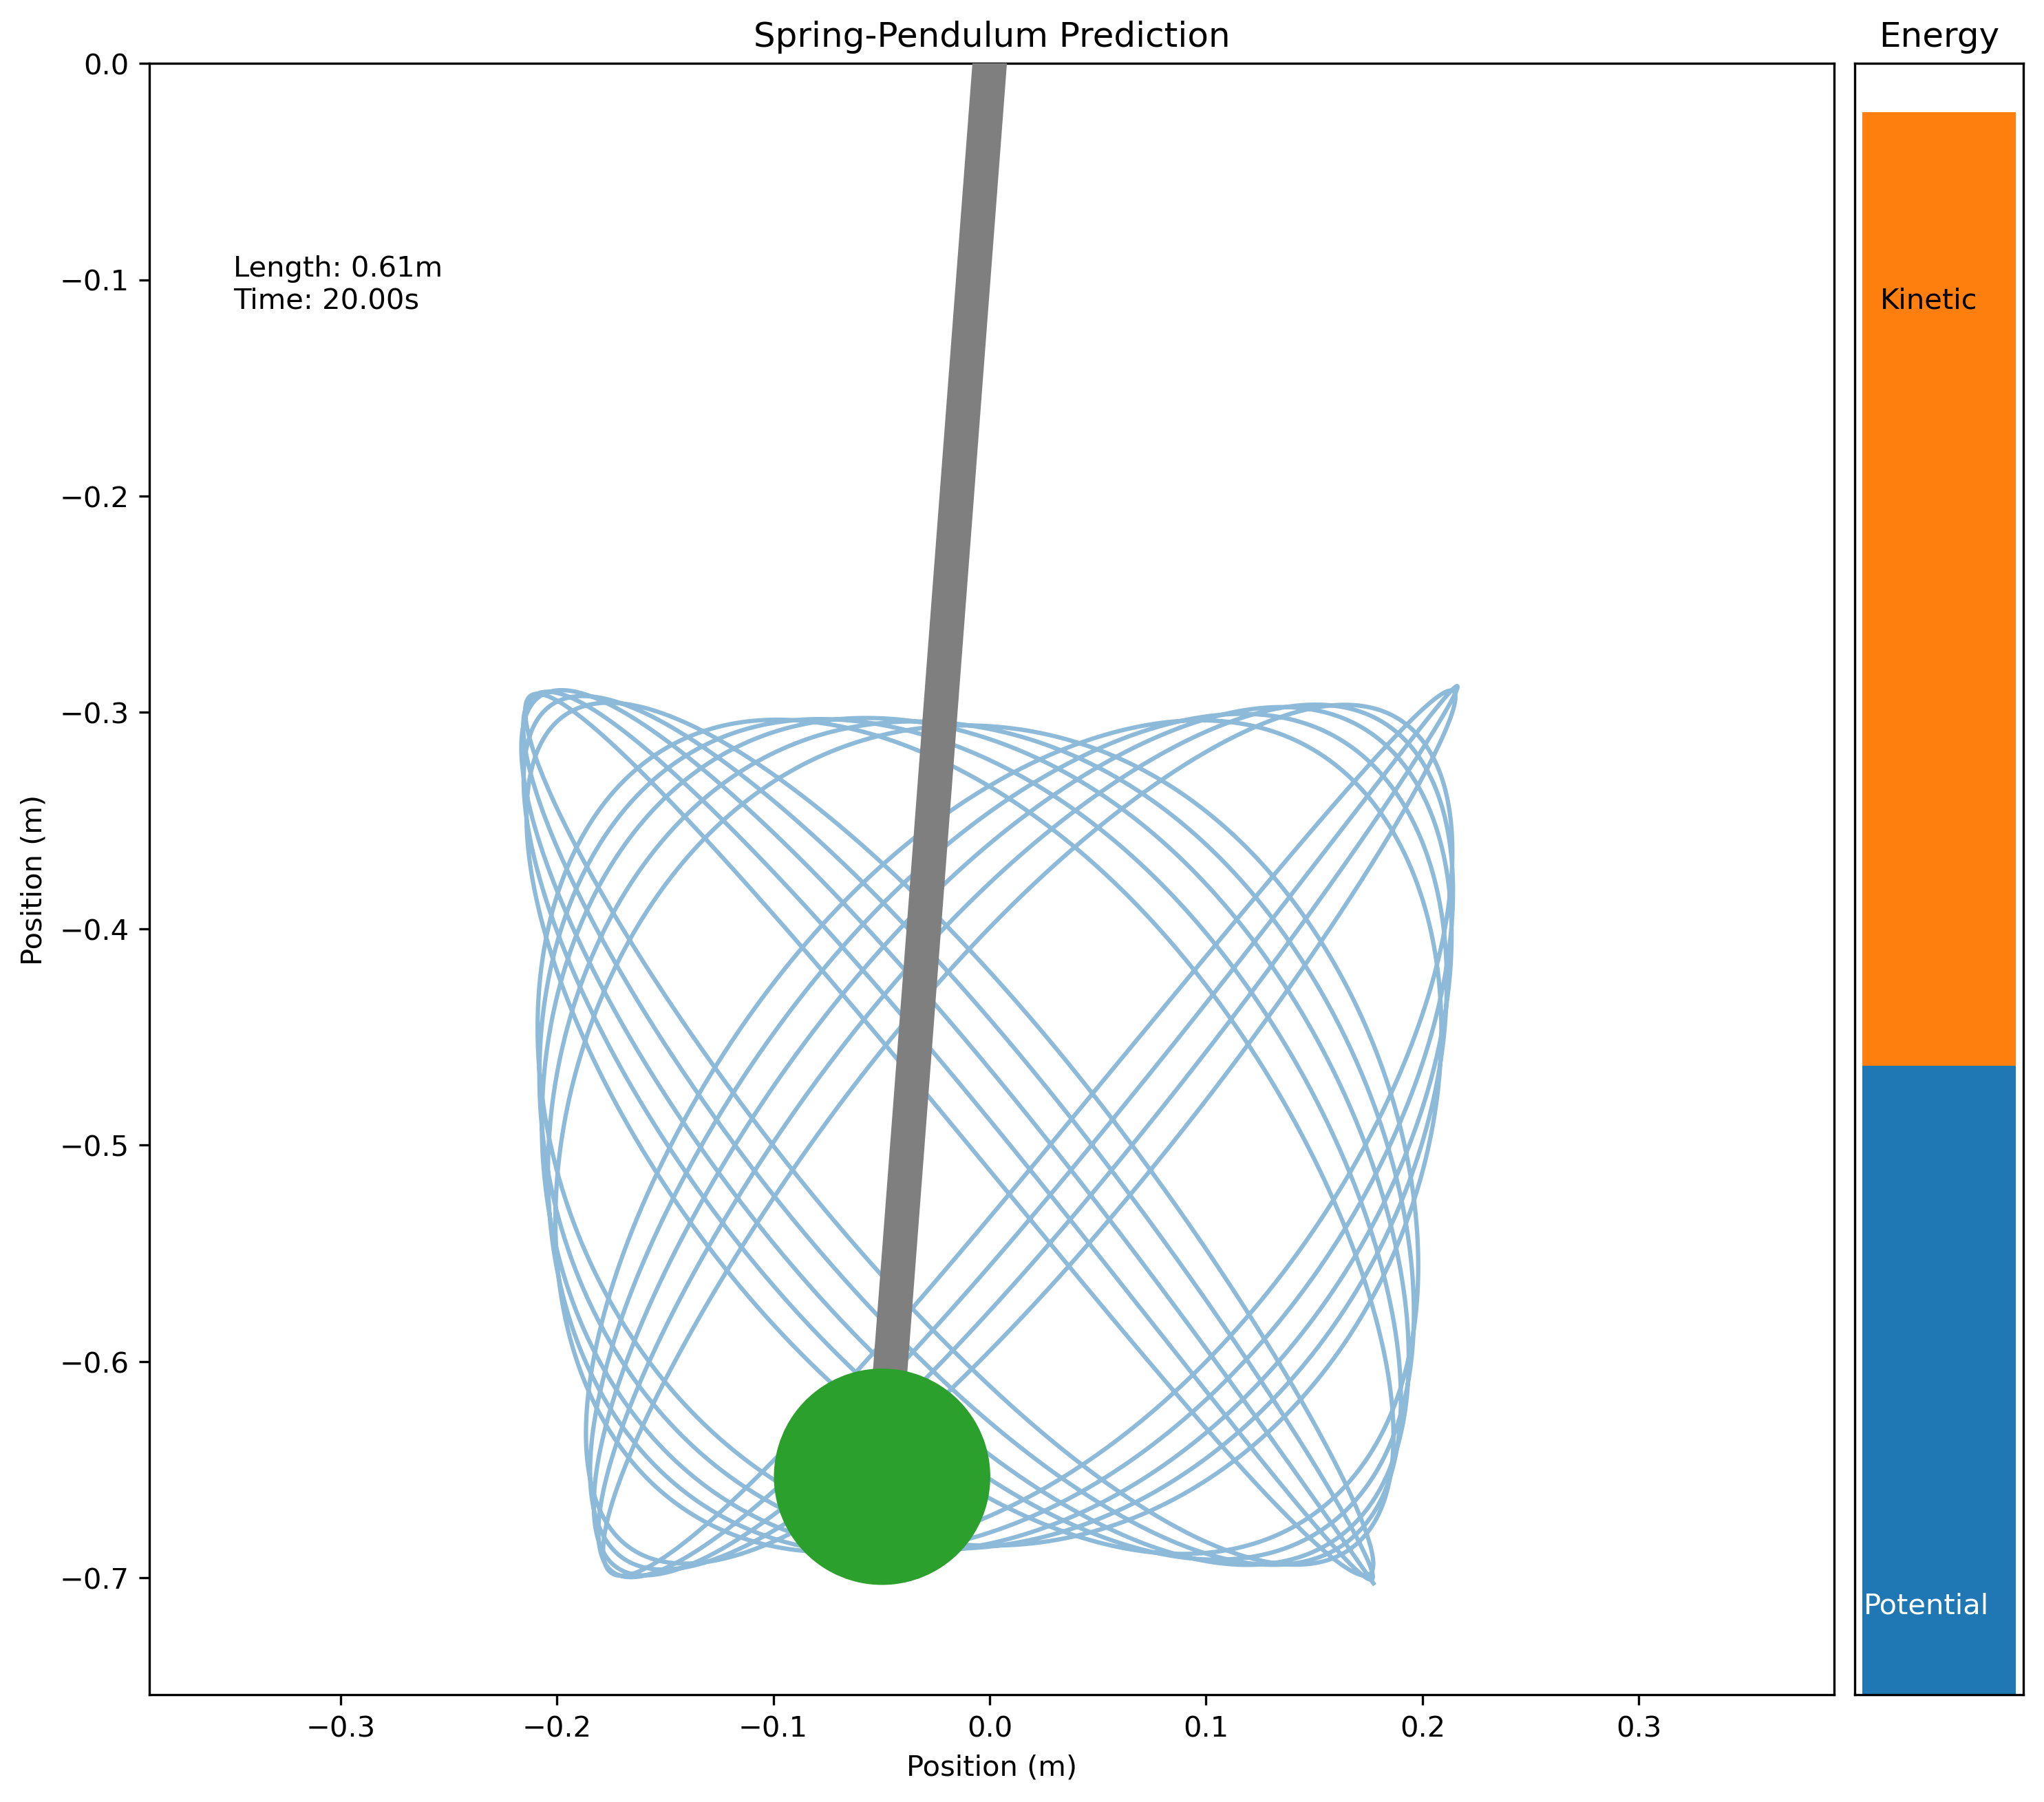

In [73]:
# Create the figure for animation

fig, ax = plt.subplots(figsize=(10,10))
fig.set_dpi(300.0)
divider = make_axes_locatable(ax)
ax1 = divider.append_axes('right', size='10%', pad=0.1)

alltheta = np.arctan(x/y)
xatmass = x-diameter/2*np.sin(alltheta)
yatmass = y-diameter/2*np.cos(alltheta)

# Setup the framerate and linearly interpolate across the available frames for target framerate and time

framerate = 30
nframes = len(x)-1
frames = np.linspace(0, nframes, int(time*framerate), dtype=int)

# Define how to animate a frame given the index

def animate(i):
    ax.clear()
    ax.plot(xatmass[0:i], yatmass[0:i], alpha=0.5, markerfacecolor='tab:blue', zorder=0)
    ax.plot([0,x[i]], [0,y[i]], linewidth=12.0, color='tab:gray', zorder=5)
    ax.add_artist(plt.Circle((xatmass[i], yatmass[i]), diameter/2, facecolor='tab:green', zorder=10))
    ax.set_ylim(*yrange)
    ax.set_xlim(*xrange)
    
    ax.set_ylabel('Position (m)')
    ax.set_xlabel('Position (m)')
    ax.set_title('Spring-Pendulum Prediction')
    
    l = np.sqrt( x[i]*x[i] + y[i]*y[i] )
    t = i/nframes*time
    ax.annotate('Length: {:.2f}m\nTime: {:.2f}s'.format(l, t), xy=[0.05,0.85], xycoords='axes fraction', zorder=15)
    
    ax.set_aspect('equal')
    
    ax1.clear()
    ax1.bar(1, vhist[i])
    ax1.bar(1, thist[i], bottom=vhist[i])
    ax1.annotate("Potential", xy=[0.05, 0.05], xycoords='axes fraction', color="white", zorder=15)
    ax1.annotate("Kinetic", xy=[0.15, 0.85], xycoords='axes fraction', color="black", zorder=15)
    ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax1.set_ylim(*erange)
    ax1.set_title('Energy')
    
    fig.tight_layout()
    
# Create the animation and save to file
    
anim = animation.FuncAnimation(fig, animate, frames = frames, interval=1/framerate*1000)
anim.save('SpringPendulumRun1.mp4')

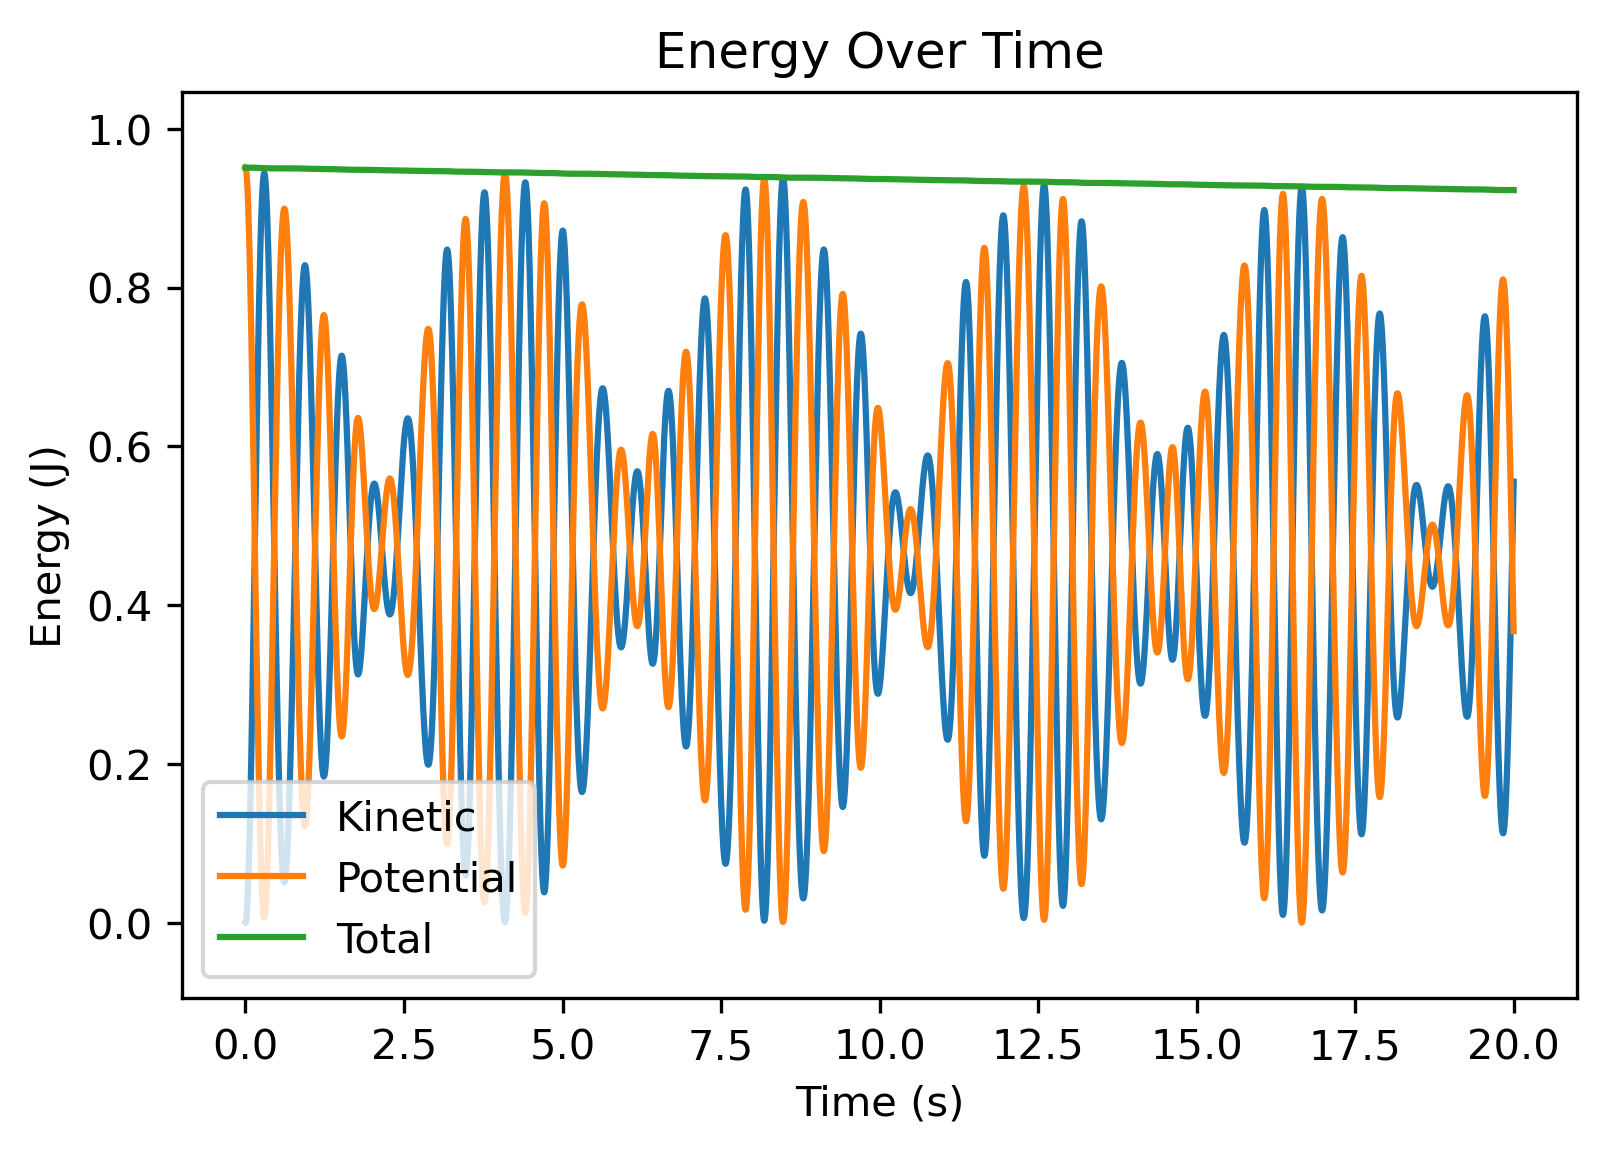

In [11]:
fig, ax = plt.subplots()
fig.set_dpi(300.0)

time = 10
framerate = 30
nframes = len(thist)-1
frames = np.linspace(0, nframes, int(time*framerate), dtype=int)

maxenergy = np.max(thist+vhist)

def animate(i):
    ax.clear()
    ax.plot(np.array(range(len(thist[0:i])))*timestep, thist[0:i], label='Kinetic')
    ax.plot(np.array(range(len(thist[0:i])))*timestep, vhist[0:i], label='Potential')
    ax.plot(np.array(range(len(thist[0:i])))*timestep, vhist[0:i]+thist[0:i], label='Total')
    
    ax.set_ylabel('Energy (J)')
    ax.set_xlabel('Time (s)')
    ax.set_title('Energy Over Time')
    ax.set_xlim(-1,21)
    ax.set_ylim(-0.1*maxenergy, 1.1*maxenergy)
    
    ax.legend(loc='lower left')
    
#     fig.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames = frames, interval=1/framerate*1000)
anim.save('EnergyRun1.mp4')